# Algorithmic Trading

# 1. Get the data

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import mplfinance as mpf
warnings.filterwarnings('ignore')

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()
#symbols_list Checa se estão corretos

In [3]:
end_date = '2024-4-26'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)
df = yf.download(tickers = symbols_list,
                start = start_date,
                end = end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-04-28 A        38.642582   41.180000   41.779999   41.060001   41.250000   
           AAL      34.468365   35.970001   37.090000   35.889999   37.040001   
           AAPL     21.643246   23.707500   24.469999   23.562500   24.402500   
           ABBV     43.371479   61.200001   62.099998   57.529999   58.560001   
           ABT      34.886677   40.419998   41.689999   39.990002   40.080002   
...                       ...         ...         ...         ...         ...   
2024-04-25 XYL     130.610001  130.610001  131.199997  128.100006  129.619995   
           YUM     141.559998  141.559998  142.169998  140.389999  141.979996   
           ZBH     119.750000  119.750000  121.349998  118.769997  120.709999   
           ZBRA    292.529999  292.529999  293.290009  271.630005  274.359985   
           ZTS     153.360001  153.360001  153.589996  150.039993  150.970001   

Price                   volume  
date       ticker               
2016-04-28 A         1549800.0  
           AAL       9836800.0  
           AAPL    328970800.0  
           ABBV     16235400.0  
           ABT      54527700.0  
...                        ...  
2024-04-25 XYL        963600.0  
           YUM       1693100.0  
           ZBH       1078800.0  
           ZBRA       674700.0  
           ZTS       4567200.0  

[992011 rows x 6 columns]

# 2.Calculate features and technical indicators for each stock.


- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume


## Candle Graph of APPL

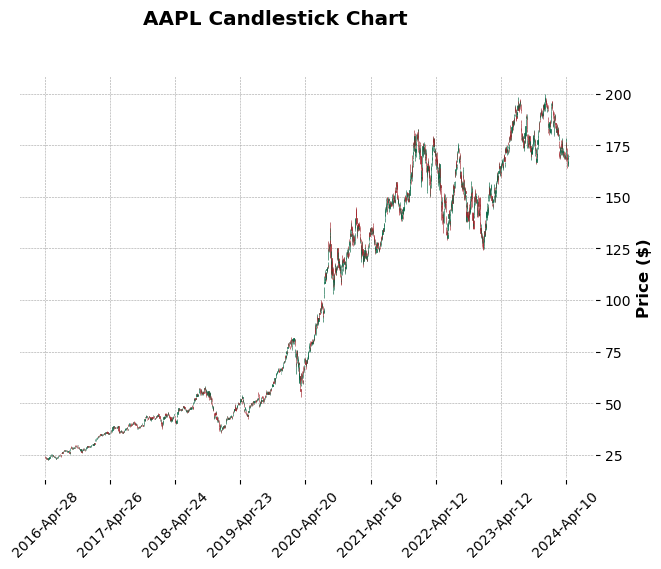

In [4]:
df.reset_index(inplace=True)
df_aapl = df[df['ticker'] == 'AAPL']

df_aapl['date'] = pd.to_datetime(df_aapl['date'])
df_aapl.set_index('date', inplace=True)


mpf.plot(df_aapl[['open', 'high', 'low', 'close', 'volume']], type='candle', style='charles', title='AAPL Candlestick Chart', ylabel='Price ($)')


## Garman Klass Volatility

$$
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
$$


In [5]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

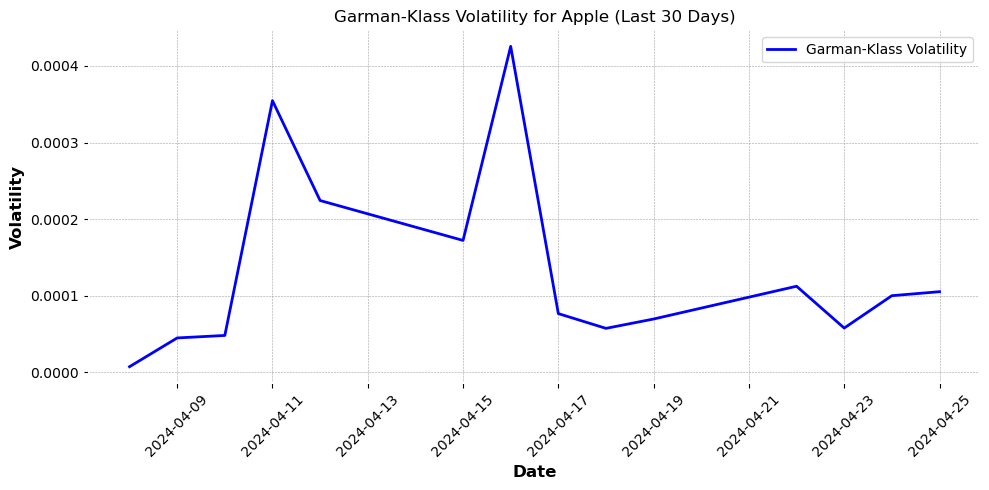

In [6]:
# Sample data frame and setting the date and ticker as index
df.set_index(['date', 'ticker'], inplace=True)

# Convert end_date to datetime, if not already (replace 'end_date' with actual end date as string or pd.Timestamp)
end_date = pd.to_datetime('2024-05-06')  # Example end date
aapl_start_date = end_date - pd.DateOffset(days=30)

# Correct slicing method using .loc and pd.IndexSlice for a range within a MultiIndex
apple_data = df.loc[pd.IndexSlice[aapl_start_date:end_date, 'AAPL'], :]

# Reset index for plotting
apple_data.reset_index(inplace=True)
apple_data['date'] = pd.to_datetime(apple_data['date'])

# Plotting (assuming 'garman_klass_vol' is a valid column in your DataFrame)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(apple_data['date'], apple_data['garman_klass_vol'], label='Garman-Klass Volatility', color='blue')
plt.title('Garman-Klass Volatility for Apple (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Relative Strengh Index (RSI)

$$
RSI_{\text{step one}} = 100 - \left[ \frac{100}{1 + \frac{\text{Average gain}}{\text{Average loss}}} \right]
$$


In [7]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=14))
# df.xs('ABBV',level=1)['rsi'].plot() 
aapl_data = df.xs('AAPL', level='ticker')


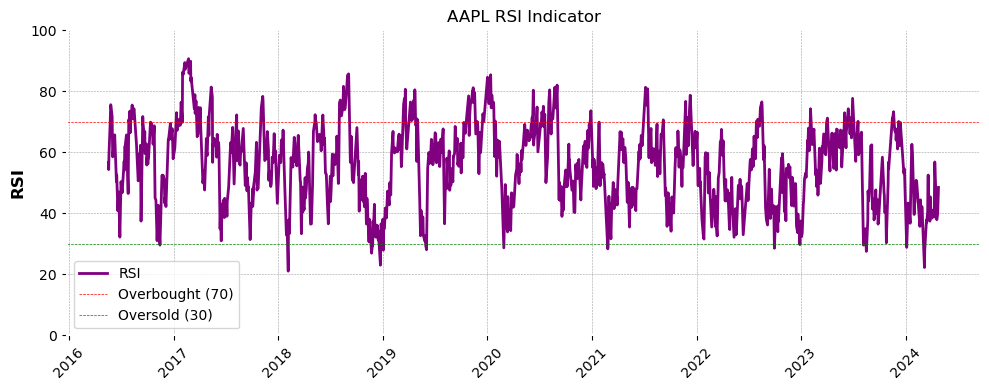

In [8]:
plt.figure(figsize=(10, 4))
plt.title('AAPL RSI Indicator')
plt.plot(aapl_data.index, aapl_data['rsi'], label='RSI', color='purple')  # Ensure 'rsi' is the column name
plt.axhline(70, color='red', linestyle='--', linewidth=0.5, label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', linewidth=0.5, label='Oversold (30)')
plt.ylim([0, 100])  # RSI ranges from 0 to 100
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.tight_layout()
plt.show()


## Bollinger Bands

In [9]:
#Fixes the None problem
def safe_bbands1(x):
    result = pandas_ta.bbands(close=np.log1p(x), length=14)
    if result is not None:
        return result.iloc[:, 0] 
    else:
        return pd.Series([None] * len(x), index=x.index)  


df['bb_low'] = df.groupby(level=1)['adj close'].transform(safe_bbands1)

def safe_bbands2(x):
    result = pandas_ta.bbands(close=np.log1p(x), length=14)
    if result is not None:
        return result.iloc[:, 1] 
    else:
        return pd.Series([None] * len(x), index=x.index)  

# Apply the safe_bbands function
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(safe_bbands2)

def safe_bbands3(x):
    result = pandas_ta.bbands(close=np.log1p(x), length=14)
    if result is not None:
        return result.iloc[:, 2]  
    else:
        return pd.Series([None] * len(x), index=x.index)  


df['bb_high'] = df.groupby(level=1)['adj close'].transform(safe_bbands3)

#Joins with df
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

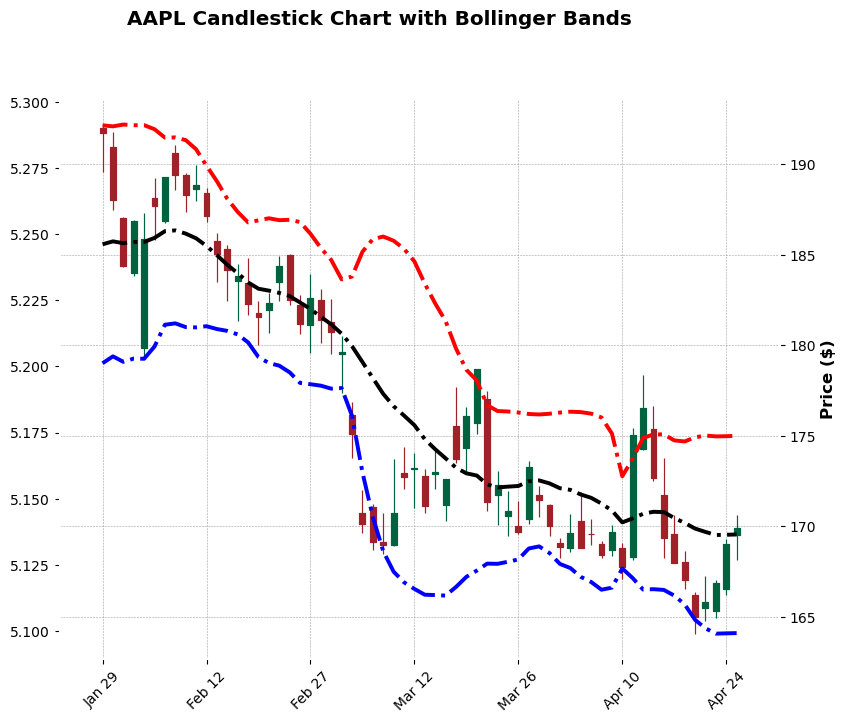

In [10]:
aapl_start_date = pd.to_datetime(end_date)-pd.DateOffset(100)


apple_data = df.loc[(slice(aapl_start_date, end_date), 'AAPL'), :]

# Normalize the DataFrame for manipulation
apple_data = apple_data.reset_index()
apple_data['date'] = pd.to_datetime(apple_data['date'])
apple_data.set_index('date', inplace=True)  # Set 'date' as the index

add_plots = [
    mpf.make_addplot(apple_data['bb_low'], color='blue', linestyle='dashdot'),
    mpf.make_addplot(apple_data['bb_mid'], color='black', linestyle='dashdot'),
    mpf.make_addplot(apple_data['bb_high'], color='red', linestyle='dashdot')
]

# Create the candlestick chart with Bollinger Bands using apple_data
mpf.plot(apple_data, type='candle', style='charles', title='AAPL Candlestick Chart with Bollinger Bands', ylabel='Price ($)', addplot=add_plots, figsize=(10, 8))

## Moving Average Convergence/Divergence

In [11]:
def compute_macd(close):
    macd_result = pandas_ta.macd(close=close, fast=12, slow=26, signal=9)  
    if macd_result is not None and not macd_result.empty:
        macd = macd_result['MACD_12_26_9']
        return macd.sub(macd.mean()).div(macd.std())
    else:
        return pd.Series([None] * len(close), index=close.index)  

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)


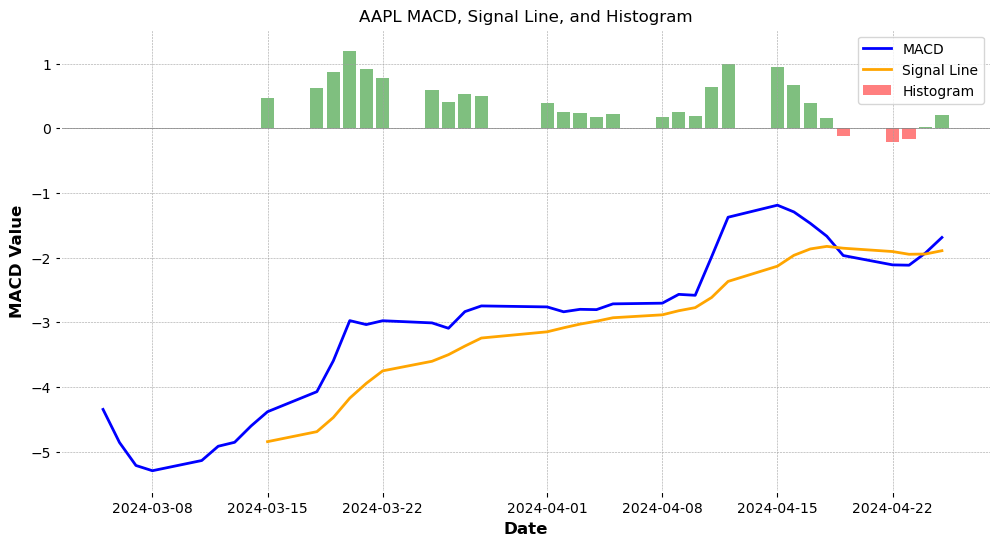

In [12]:
# Convert the Series to DataFrame if necessary, or ensure your data is in DataFrame format
if isinstance(apple_data['adj close'], pd.Series):
    close_prices = apple_data['adj close'].to_frame(name='close')

# Calculate MACD using pandas_ta
macd = pandas_ta.macd(close_prices['close'], fast=12, slow=26, signal=9)

# Add MACD calculations to the original data frame for plotting
apple_data['MACD'] = macd['MACD_12_26_9']
apple_data['Signal'] = macd['MACDs_12_26_9']
apple_data['Histogram'] = macd['MACDh_12_26_9']


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(apple_data.index, apple_data['MACD'], label='MACD', color='blue')
ax.plot(apple_data.index, apple_data['Signal'], label='Signal Line', color='orange')
ax.bar(apple_data.index, apple_data['Histogram'], label='Histogram', color=apple_data['Histogram'].apply(lambda x: 'green' if x > 0 else 'red'), alpha=0.5)

ax.axhline(0, color='gray', linewidth=0.5)  # Adds a baseline at 0

ax.set_title('AAPL MACD, Signal Line, and Histogram')
ax.set_xlabel('Date')
ax.set_ylabel('MACD Value')
ax.legend()
plt.show()

## Dolar Volume

In [13]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

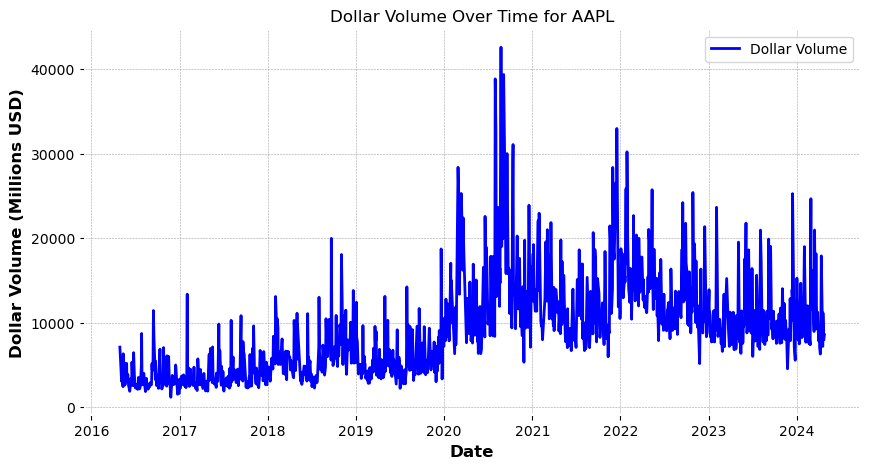

In [14]:
# Reset the index
df_reset = df.reset_index()

# Convert the 'date' column to datetime
df_reset['date'] = pd.to_datetime(df_reset['date'])

# Unstack the data
df_unstacked = df_reset.set_index(['date', 'ticker']).unstack()

# Now plot the data for 'AAPL'
plt.figure(figsize=(10, 5))
plt.plot(df_unstacked.index, df_unstacked[('dollar_volume', 'AAPL')], label='Dollar Volume', color='blue')
plt.title('Dollar Volume Over Time for AAPL')
plt.xlabel('Date')
plt.ylabel('Dollar Volume (Millions USD)')
plt.legend()
plt.grid(True)
plt.show()


# 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

In [15]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-06-30 A           99.655609   41.736317         -0.000631  48.947237   
           AAL        351.266371   27.206572          0.000214  41.682655   
           AAPL      3129.251164   21.951826         -0.001929  49.183098   
           ABBV       418.335094   43.874641         -0.045188  54.561728   
           ABT        338.847595   33.928627         -0.006377  56.895661   
...                          ...         ...               ...        ...   
2024-04-30 XYL        137.212962  130.610001          0.000264  61.482745   
           YUM        263.628668  141.559998          0.000076  65.668163   
           ZBH        137.037646  119.750000          0.000206  35.636078   
           ZBRA        93.501512  292.529999          0.001355  56.172272   
           ZTS        652.073789  153.360001          0.000178  39.809619   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-06-30 A       3.710604  3.763386  3.816168 -1.165065  -0.18043  
           AAL     3.245315  3.361554  3.477793  0.661601 -1.537915  
           AAPL    3.099621  3.131916  3.164211 -1.196016 -0.301643  
           ABBV    3.752352  3.779162  3.805972 -0.988646 -0.347335  
           ABT     3.482479  3.520203  3.557928 -1.147698 -0.217445  
...                     ...       ...       ...       ...       ...  
2024-04-30 XYL     4.843367  4.863772  4.884178  0.417922  0.290952  
           YUM     4.914062  4.937850  4.961639  0.145839   0.47798  
           ZBH     4.769259  4.821754  4.874250 -0.506041 -0.807851  
           ZBRA    5.574158  5.654944  5.735729  0.266698 -0.380931  
           ZTS     4.957942  5.043798  5.129654  1.161820 -2.904211  

[46838 rows x 9 columns]

### Pegar as 150 mais liquidas

In [16]:
data['dollar_volume'] = (data.loc[: , 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-05-31 AAL      46.985199         -0.000056  62.928680  3.783374   
           AAPL     35.748737         -0.002044  58.398391  3.592311   
           ABBV     48.592537         -0.037005  53.229576  3.889364   
           ABT      40.407570         -0.004774  69.171753  3.653847   
           ACN     112.053123         -0.003928  65.857072  4.689061   
...                       ...               ...        ...       ...   
2024-04-30 VRTX    397.700012          0.000319  41.976274  5.970426   
           VZ       39.220001          0.000237  42.896054  3.682108   
           WFC      59.930000          0.000205  63.324078  4.025860   
           WMT      60.209999          0.000065  54.164438  4.095911   
           XOM     121.330002          0.000189  69.809165  4.780308   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-05-31 AAL     3.834838  3.886303  0.546729  1.300908  
           AAPL    3.610172  3.628034 -1.172050 -0.004005  
           ABBV    3.902556  3.915748 -1.591576 -0.176286  
           ABT     3.685678  3.717508 -1.332553 -0.069103  
           ACN     4.709108  4.729156 -1.211398  0.023965  
...                     ...       ...       ...       ...  
2024-04-30 VRTX    5.990119  6.009811  0.834946 -1.340993  
           VZ      3.712749  3.743390  0.063678 -0.491815  
           WFC     4.083979  4.142097  0.347658  1.178933  
           WMT     4.108439  4.120967  0.723423 -0.221191  
           XOM     4.798965  4.817622  0.486938  1.602672  

[12516 rows x 8 columns]

# 4. Compute Monthly Returns for Various Time Periods as Features.

To grasp the dynamics of time series, such as momentum patterns, we calculate historical returns using the method .pct_change(lag), which measures returns over different monthly periods specified by lags.

In [17]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-05-31 AAL      42.618011          0.000660  47.043754  3.744283   
           AAPL     44.410904         -0.001003  60.497405  3.811995   
           ABBV     75.292374         -0.032835  43.946897  4.336715   
           ABT      55.550392         -0.004457  54.404581  4.018188   
           ACN     142.810822         -0.002942  54.124052  4.953789   
...                       ...               ...        ...       ...   
2024-04-30 VRTX    397.700012          0.000319  41.976274  5.970426   
           VZ       39.220001          0.000237  42.896054  3.682108   
           WFC      59.930000          0.000205  63.324078  4.025860   
           WMT      60.209999          0.000065  54.164438  4.095911   
           XOM     121.330002          0.000189  69.809165  4.780308   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-05-31 AAL     3.773151  3.802020  1.369952 -0.574774   0.016581   
           AAPL    3.819711  3.827426 -1.010888  0.144747   0.135124   
           ABBV    4.382393  4.428072  0.500245  0.063068   0.024754   
           ABT     4.036299  4.054411 -0.761826   0.27137   0.058490   
           ACN     4.966268  4.978746 -0.839764 -0.038901   0.030026   
...                     ...       ...       ...       ...        ...   
2024-04-30 VRTX    5.990119  6.009811  0.834946 -1.340993  -0.048587   
           VZ      3.712749  3.743390  0.063678 -0.491815  -0.050164   
           WFC     4.083979  4.142097  0.347658  1.178933   0.033989   
           WMT     4.108439  4.120967  0.723423 -0.221191   0.000665   
           XOM     4.798965  4.817622  0.486938  1.602672   0.043789   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-05-31 AAL     -0.083533  -0.069961  -0.023688  -0.002302   -0.008097  
           AAPL     0.057391   0.017418   0.015402   0.015909    0.018245  
           ABBV     0.027693  -0.047916   0.006367   0.033601    0.037166  
           ABT      0.015782   0.008199   0.016325   0.022849    0.026878  
           ACN      0.011704  -0.008131   0.009999   0.021704    0.020418  
...                      ...        ...        ...        ...         ...  
2024-04-30 VRTX    -0.027766  -0.028233   0.015748   0.013547    0.012967  
           VZ      -0.002062  -0.020036   0.024106   0.021833    0.006827  
           WFC      0.038302   0.063452   0.073570   0.032142    0.037522  
           WMT      0.015282   0.031276   0.018043   0.014866    0.016283  
           XOM      0.077418   0.060027   0.026143   0.016802    0.005022  

[10361 rows x 14 columns]

# 5. Finding correlation between the days of the week and how the market acts

In [18]:
# Extract data for a specific ticker, AAPL in this case
g = df.xs('AAPL', level=1)

g.index = pd.to_datetime(g.index.get_level_values(0))  # Adjust the level if necessary

# Calculate daily returns as percentage changes in the closing price
g['daily_returns'] = g['adj close'].pct_change()

# Determine the day of the week for each date (Monday=0, Sunday=6)
g['day_of_week'] = g.index.dayofweek

# Calculate the standard deviation of returns for each day of the week
weekly_volatility = g.groupby('day_of_week')['daily_returns'].std()

# Map day indices to day names
days = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
weekly_volatility.index = weekly_volatility.index.map(days)

# Display the volatility
print(weekly_volatility)

# Identify the day with the highest volatility
most_volatile_day = weekly_volatility.idxmax()
print(f"The most volatile day of the week for AAPL is {most_volatile_day} with a standard deviation of {weekly_volatility.max():.4f}.")


day_of_week
Monday       0.019770
Tuesday      0.016514
Wednesday    0.017337
Thursday     0.018606
Friday       0.019042
Name: daily_returns, dtype: float64
The most volatile day of the week for AAPL is Monday with a standard deviation of 0.0198.


In [19]:
g['daily_returns'] = g['adj close'].pct_change()
# Determine the day of the week (Monday=0, ..., Sunday=6)
g['day_of_week'] = g.index.dayofweek
# Calculate the mean of daily returns grouped by the day of the week
average_growth_by_day = g.groupby('day_of_week')['daily_returns'].mean()

# Map day indices to day names for better readability
days = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
average_growth_by_day.index = average_growth_by_day.index.map(days)

# Display the average growth by day of the week
print(average_growth_by_day)

# Identify the day with the highest average growth
day_with_most_growth = average_growth_by_day.idxmax()
print(f"The day of the week with the most growth for the S&P 500 is {day_with_most_growth} with an average growth of {average_growth_by_day.max() * 100:.2f}%.")


day_of_week
Monday       0.002455
Tuesday      0.001706
Wednesday    0.002064
Thursday    -0.000229
Friday       0.000047
Name: daily_returns, dtype: float64
The day of the week with the most growth for the S&P 500 is Monday with an average growth of 0.25%.


# 6. Download Fama-French Factors and Calculate Rolling Factor Betas.



The plan is to incorporate the Fama-French data to estimate the exposure of assets to common risk factors through linear regression analysis.

The five Fama-French factors—market risk, size, value, operating profitability, and investment—have been empirically demonstrated to explain asset returns effectively. These factors are frequently utilized to evaluate the risk/return profile of investment portfolios. Given their relevance, it makes sense to include historical factor exposures as financial features in our models.

To access historical factor returns, we can use the pandas-datareader. We will estimate historical exposures by applying RollingOLS for rolling linear regression.

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)$$
E(R_p) = R_f + \beta_{m}(R_M - R_f) + \beta_{smb} \cdot SMB + \beta_{hml} \cdot HML + \beta_{rmw} \cdot RMW + \beta_{cma} \cdot CMA
$$

### Where:
- $E(R_p)$ is the expected return on the portfolio.
- $R_f$ is the risk-free rate.
- $R_M$ is the return on the market portfolio.
- $\beta_{m}$, $\beta_{smb}$, $\beta_{hml}$, $\beta_{rmw}$, and $\beta_{cma}$ are the portfolio's sensitivities to the respective factors:
  - Market risk premium 
  - Small Minus Big (SMB)
  - High Minus Low (HML)
  - Robust Minus Weak (RMW)
  - Conservative Minus Aggressive (CMA)

### Where:
#### 1. Market Risk Premium (R_M - R_f)
The market risk premium represents the excess return of the market portfolio over the risk-free rate. It is calculated as:
$$
\text{Market Risk Premium} = R_M - R_f
$$

#### 2. SMB (Small Minus Big)
The SMB factor captures the historical excess returns of small-cap stocks over big-cap stocks. It is calculated as the average return of portfolios composed of small-cap stocks minus the average return of portfolios composed of big-cap stocks:
$$
SMB = \text{Average return on three small portfolios} - \text{Average return on three big portfolios}
$$

#### 3. HML (High Minus Low)
The HML factor measures the excess returns of stocks with high book-to-market values over those with low book-to-market values. It is constructed as:
$$
HML = \text{Average return on two value portfolios} - \text{Average return on two growth portfolios}
$$

#### 4. RMW (Robust Minus Weak)
The RMW factor contrasts the returns of companies with high operating profitability against those with low operating profitability:
$$
RMW = \text{Average return on two robust operating profit portfolios} - \text{Average return on two weak operating profit portfolios}
$$

#### 5. CMA (Conservative Minus Aggressive)
The CMA factor captures the differential returns between firms that invest conservatively and those that invest aggressively. It is computed as:
$$
CMA = \text{Average return on two conservative investment portfolios} - \text{Average return on two aggressive investment portfolios}
$$



In [20]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-05-31 AAL     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.016581
           AAPL    0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.135124
           ABBV    0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.024754
           ABT     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.058490
           ACN     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.030026
...                   ...     ...     ...     ...     ...        ...
2024-03-31 VRTX    0.0283 -0.0116  0.0419  0.0148  0.0118  -0.006489
           VZ      0.0283 -0.0116  0.0419  0.0148  0.0118   0.048476
           WFC     0.0283 -0.0116  0.0419  0.0148  0.0118   0.042634
           WMT     0.0283 -0.0116  0.0419  0.0148  0.0118   0.030113
           XOM     0.0283 -0.0116  0.0419  0.0148  0.0118   0.112132

[10217 rows x 6 columns]

Selecting the companies that have at least 12 months of data

In [21]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 12]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-05-31 AAL     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.016581
           AAPL    0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.135124
           ABBV    0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.024754
           ABT     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.058490
           ACN     0.0265  0.0473 -0.0320 -0.0204 -0.0150   0.030026
...                   ...     ...     ...     ...     ...        ...
2024-03-31 VRTX    0.0283 -0.0116  0.0419  0.0148  0.0118  -0.006489
           VZ      0.0283 -0.0116  0.0419  0.0148  0.0118   0.048476
           WFC     0.0283 -0.0116  0.0419  0.0148  0.0118   0.042634
           WMT     0.0283 -0.0116  0.0419  0.0148  0.0118   0.030113
           XOM     0.0283 -0.0116  0.0419  0.0148  0.0118   0.112132

[10176 rows x 6 columns]

In [22]:

betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-05-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-03-31 VRTX    0.268801  0.654605 -0.656893  0.402016  0.781699
           VZ      0.506034 -1.155973  0.600672  0.007152 -0.205276
           WFC     1.173196  0.311765  1.186081 -0.546274 -0.753657
           WMT     0.520277  0.219253 -0.675270  0.724902  0.581208
           XOM     0.808571 -0.071684  0.667509  0.882268  0.351960

[10176 rows x 5 columns]

Joins with the main features dataframe

In [23]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10137 entries, (Timestamp('2018-05-31 00:00:00'), 'AAL') to (Timestamp('2024-04-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10137 non-null  float64
 1   rsi               10137 non-null  float64
 2   bb_low            10137 non-null  float64
 3   bb_mid            10137 non-null  float64
 4   bb_high           10137 non-null  float64
 5   atr               10137 non-null  float64
 6   macd              10137 non-null  object 
 7   return_1m         10137 non-null  float64
 8   return_2m         10137 non-null  float64
 9   return_3m         10137 non-null  float64
 10  return_6m         10137 non-null  float64
 11  return_9m         10137 non-null  float64
 12  return_12m        10137 non-null  float64
 13  Mkt-RF            10137 non-null  float64
 14  SMB               10137 non-null  float64
 15  HML        

# 7. Implement a K-Means Clustering Algorithm each month to categorize assets into groups based on their characteristics.

In [24]:
from sklearn.cluster import KMeans

def get_clusters(data):
    data['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(data).labels_
    return data

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-05-31 AAL             0.000660  47.043754  3.744283  3.773151  3.802020   
           AAPL           -0.001003  60.497405  3.811995  3.819711  3.827426   
           ABBV           -0.032835  43.946897  4.336715  4.382393  4.428072   
           ABT            -0.004457  54.404581  4.018188  4.036299  4.054411   
           ACN            -0.002942  54.124052  4.953789  4.966268  4.978746   
...                             ...        ...       ...       ...       ...   
2024-04-30 VRTX            0.000319  41.976274  5.970426  5.990119  6.009811   
           VZ              0.000237  42.896054  3.682108  3.712749  3.743390   
           WFC             0.000205  63.324078  4.025860  4.083979  4.142097   
           WMT             0.000065  54.164438  4.095911  4.108439  4.120967   
           XOM             0.000189  69.809165  4.780308  4.798965  4.817622   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-05-31 AAL     1.369952 -0.574774   0.016581  -0.083533  -0.069961   
           AAPL   -1.010888  0.144747   0.135124   0.057391   0.017418   
           ABBV    0.500245  0.063068   0.024754   0.027693  -0.047916   
           ABT    -0.761826   0.27137   0.058490   0.015782   0.008199   
           ACN    -0.839764 -0.038901   0.030026   0.011704  -0.008131   
...                     ...       ...        ...        ...        ...   
2024-04-30 VRTX    0.834946 -1.340993  -0.048587  -0.027766  -0.028233   
           VZ      0.063678 -0.491815  -0.050164  -0.002062  -0.020036   
           WFC     0.347658  1.178933   0.033989   0.038302   0.063452   
           WMT     0.723423 -0.221191   0.000665   0.015282   0.031276   
           XOM     0.486938  1.602672   0.043789   0.077418   0.060027   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-05-31 AAL     -0.023688  -0.002302   -0.008097  1.222482  1.432153   
           AAPL     0.015402   0.015909    0.018245  1.321416 -0.360377   
           ABBV     0.006367   0.033601    0.037166  0.465361  0.544626   
           ABT      0.016325   0.022849    0.026878  0.801229 -0.144189   
           ACN      0.009999   0.021704    0.020418  1.219369 -0.185400   
...                      ...        ...         ...       ...       ...   
2024-04-30 VRTX     0.015748   0.013547    0.012967  0.509936  0.049425   
           VZ       0.024106   0.021833    0.006827  0.471202 -0.417800   
           WFC      0.073570   0.032142    0.037522  1.073263 -0.093282   
           WMT      0.018043   0.014866    0.016283  0.605785 -0.404731   
           XOM      0.026143   0.016802    0.005022  1.089634  0.189620   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-05-31 AAL     0.477837  0.086116  0.803494        1  
           AAPL   -0.616529  0.441142  0.616616        2  
           ABBV   -0.190806  0.538560  0.417969        1  
           ABT    -0.458058  0.266269  0.949127        2  
           ACN    -0.267127  0.317631  0.120589        2  
...                     ...       ...       ...      ...  
2024-04-30 VRTX   -0.890134  0.096526  0.857551        0  
           VZ      0.187597  0.240248  0.286741        0  
           WFC     1.560105 -0.765963 -0.813226        2  
           WMT    -0.362730  0.251169  0.693313        3  
           XOM     0.795500 -0.466739  0.496619        2  

[10137 rows x 19 columns]

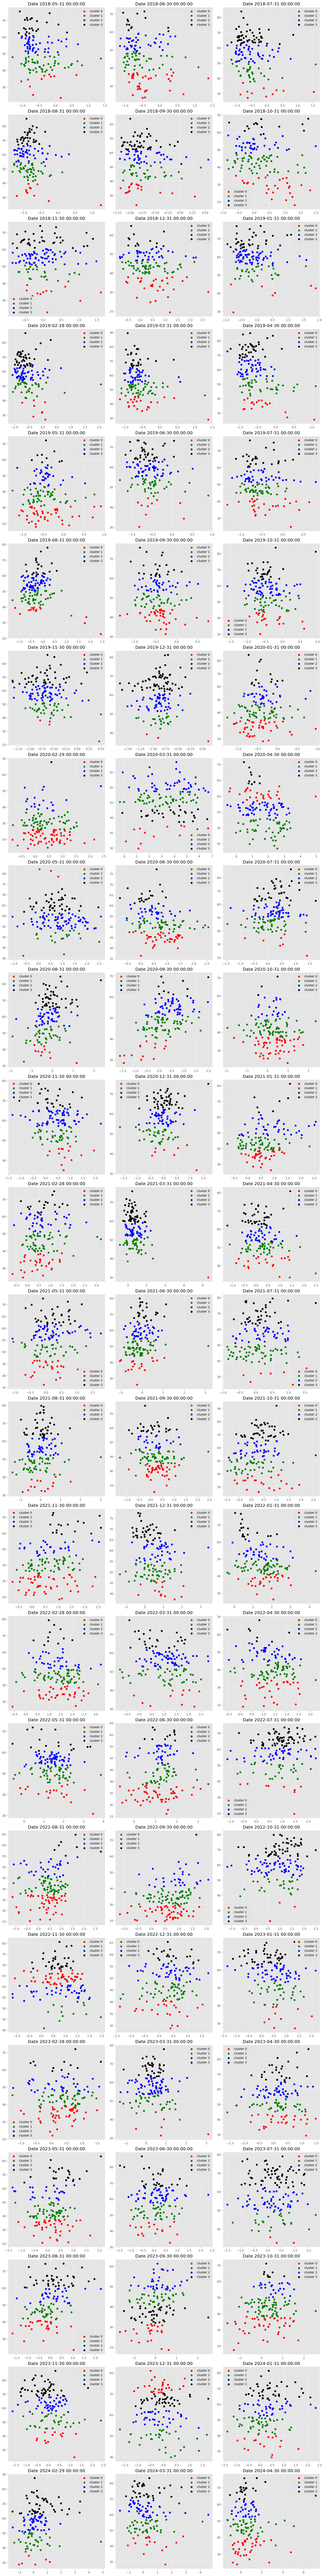

In [33]:
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported for array manipulations

def plot_clusters(data, ax):
    colors = ['red', 'green', 'blue', 'black']  # Define colors for different clusters
    labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']

    # Plot each cluster
    for cluster in range(4):
        cluster_data = data[data['cluster'] == cluster]
        ax.scatter(cluster_data.iloc[:, 5], cluster_data.iloc[:, 1], color=colors[cluster], label=labels[cluster])
    
    ax.legend()  # Show the legend

def plot_all_clusters(data):
    # Extract unique dates and determine the number of rows needed for the subplots
    unique_dates = data.index.get_level_values('date').unique()
    n_dates = len(unique_dates)
    rows = (n_dates + 2) // 3  # Determine the number of rows needed
    
    # Create a figure with subplots
    fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows), constrained_layout=True)

    # If axs is not an array of arrays, make it one
    if n_dates == 1:
        axs = np.array([axs])
    axs = axs.flatten()

    # Plot each date in its respective subplot
    for ax, date in zip(axs, unique_dates):
        g = data.xs(date, level='date')
        ax.set_title(f'Date {date}')
        plot_clusters(g, ax)

    # Hide unused axes if the number of dates is not a multiple of 3
    for i in range(n_dates, len(axs)):
        axs[i].set_visible(False)

    plt.show()

# Example of how to call the function with your data
plot_all_clusters(data)

The clustering process is inherently random, leading to inconsistencies in how clusters are represented across different time periods. For instance, Cluster 0 might represent the lowest values in some months and the highest in others. To address this issue, it is essential to establish a consistent reference point by defining the position of the centroid for each cluster. This step will help standardize the cluster assignments over time, ensuring that each cluster consistently represents the same type of data points across different months.

## 7.1 Solving the cluster problem

To effectively target stocks with the highest momentum, I have decided to determine the center of the clusters by using specific RSI (Relative Strength Index) values as benchmarks. This approach will allow us to focus on stocks that demonstrate strong upward momentum, ensuring that our investment strategy is aligned with the most promising opportunities. By setting these target RSI values, we can better position our clusters and optimize our investment decisions.

In [25]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [26]:
data = data.drop('cluster', axis=1)

def get_clusters(data):
    data['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(data).labels_
    return data

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-05-31 AAL             0.000660  47.043754  3.744283  3.773151  3.802020   
           AAPL           -0.001003  60.497405  3.811995  3.819711  3.827426   
           ABBV           -0.032835  43.946897  4.336715  4.382393  4.428072   
           ABT            -0.004457  54.404581  4.018188  4.036299  4.054411   
           ACN            -0.002942  54.124052  4.953789  4.966268  4.978746   
...                             ...        ...       ...       ...       ...   
2024-04-30 VRTX            0.000319  41.976274  5.970426  5.990119  6.009811   
           VZ              0.000237  42.896054  3.682108  3.712749  3.743390   
           WFC             0.000205  63.324078  4.025860  4.083979  4.142097   
           WMT             0.000065  54.164438  4.095911  4.108439  4.120967   
           XOM             0.000189  69.809165  4.780308  4.798965  4.817622   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-05-31 AAL     1.369952 -0.574774   0.016581  -0.083533  -0.069961   
           AAPL   -1.010888  0.144747   0.135124   0.057391   0.017418   
           ABBV    0.500245  0.063068   0.024754   0.027693  -0.047916   
           ABT    -0.761826   0.27137   0.058490   0.015782   0.008199   
           ACN    -0.839764 -0.038901   0.030026   0.011704  -0.008131   
...                     ...       ...        ...        ...        ...   
2024-04-30 VRTX    0.834946 -1.340993  -0.048587  -0.027766  -0.028233   
           VZ      0.063678 -0.491815  -0.050164  -0.002062  -0.020036   
           WFC     0.347658  1.178933   0.033989   0.038302   0.063452   
           WMT     0.723423 -0.221191   0.000665   0.015282   0.031276   
           XOM     0.486938  1.602672   0.043789   0.077418   0.060027   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-05-31 AAL     -0.023688  -0.002302   -0.008097  1.222482  1.432153   
           AAPL     0.015402   0.015909    0.018245  1.321416 -0.360377   
           ABBV     0.006367   0.033601    0.037166  0.465361  0.544626   
           ABT      0.016325   0.022849    0.026878  0.801229 -0.144189   
           ACN      0.009999   0.021704    0.020418  1.219369 -0.185400   
...                      ...        ...         ...       ...       ...   
2024-04-30 VRTX     0.015748   0.013547    0.012967  0.509936  0.049425   
           VZ       0.024106   0.021833    0.006827  0.471202 -0.417800   
           WFC      0.073570   0.032142    0.037522  1.073263 -0.093282   
           WMT      0.018043   0.014866    0.016283  0.605785 -0.404731   
           XOM      0.026143   0.016802    0.005022  1.089634  0.189620   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-05-31 AAL     0.477837  0.086116  0.803494        1  
           AAPL   -0.616529  0.441142  0.616616        2  
           ABBV   -0.190806  0.538560  0.417969        1  
           ABT    -0.458058  0.266269  0.949127        2  
           ACN    -0.267127  0.317631  0.120589        2  
...                     ...       ...       ...      ...  
2024-04-30 VRTX   -0.890134  0.096526  0.857551        1  
           VZ      0.187597  0.240248  0.286741        1  
           WFC     1.560105 -0.765963 -0.813226        3  
           WMT    -0.362730  0.251169  0.693313        2  
           XOM     0.795500 -0.466739  0.496619        3  

[10137 rows x 19 columns]

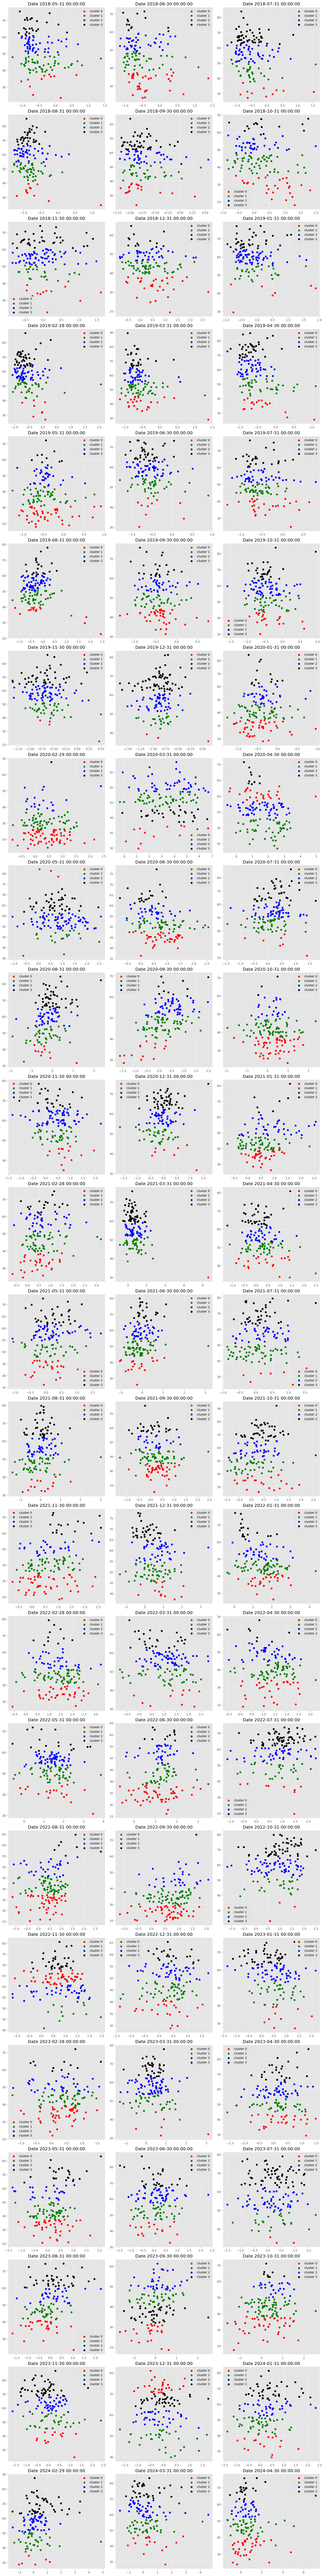

In [34]:
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported for array manipulations

def plot_clusters(data, ax):
    colors = ['red', 'green', 'blue', 'black']  # Define colors for different clusters
    labels = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']

    # Plot each cluster
    for cluster in range(4):
        cluster_data = data[data['cluster'] == cluster]
        ax.scatter(cluster_data.iloc[:, 5], cluster_data.iloc[:, 1], color=colors[cluster], label=labels[cluster])
    
    ax.legend()  # Show the legend

def plot_all_clusters(data):
    # Extract unique dates and determine the number of rows needed for the subplots
    unique_dates = data.index.get_level_values('date').unique()
    n_dates = len(unique_dates)
    rows = (n_dates + 2) // 3  # Determine the number of rows needed
    
    # Create a figure with subplots
    fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows), constrained_layout=True)

    # If axs is not an array of arrays, make it one
    if n_dates == 1:
        axs = np.array([axs])
    axs = axs.flatten()

    # Plot each date in its respective subplot
    for ax, date in zip(axs, unique_dates):
        g = data.xs(date, level='date')
        ax.set_title(f'Date {date}')
        plot_clusters(g, ax)

    # Hide unused axes if the number of dates is not a multiple of 3
    for i in range(n_dates, len(axs)):
        axs[i].set_visible(False)

    plt.show()

# Example of how to call the function with your data
plot_all_clusters(data)

# 8. Each month, select assets from clusters and construct a portfolio aimed at maximizing the Sharpe ratio using the Efficient Frontier. This strategy seeks to optimize returns for a given level of risk.

First, we will filter for stocks that align with the cluster we've identified based on our hypothesis.

Hypothesis: Momentum persists, and stocks clustered around an RSI 70 centroid are likely to continue outperforming in the subsequent month. Therefore, I will select stocks from cluster 3 for inclusion.

In [27]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}


# Creating the stocks to invest 
for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()



filtered_df

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-06-01 ADBE            0.000167  70.715512  5.457172  5.489854  5.522536   
           AMD             0.000151  75.406332  2.563765  2.639367  2.714969   
           AMZN            0.000029  65.375477  4.372309  4.393217  4.414125   
           AVGO           -0.013646  65.089943  5.258962  5.298490  5.338017   
           BIIB            0.000428  68.846505  5.614695  5.650932  5.687169   
...                             ...        ...       ...       ...       ...   
2024-05-01 SCHW            0.000191  68.962728  4.257017  4.301039  4.345061   
           TMUS            0.000221  63.307402  5.071863  5.090082  5.108302   
           UAL             0.000940  70.002163  3.659455  3.871776  4.084097   
           WFC             0.000205  63.324078  4.025860  4.083979  4.142097   
           XOM             0.000189  69.809165  4.780308  4.798965  4.817622   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-06-01 ADBE   -0.755147  0.440472   0.124910   0.074080   0.060288   
           AMD    -1.072954  0.046998   0.261948   0.168832   0.042739   
           AMZN   -0.950787   0.25783   0.040539   0.061104   0.025184   
           AVGO   -0.780800 -0.158631   0.098727   0.034253   0.012428   
           BIIB   -0.260586  0.781949   0.074415   0.036124   0.005700   
...                     ...       ...        ...        ...        ...   
2024-05-01 SCHW    0.048157  1.000296   0.035250   0.058982   0.061189   
           TMUS   -0.136166 -0.089987   0.005085   0.002294   0.007130   
           UAL     0.256995  1.283075   0.117586   0.084575   0.089469   
           WFC     0.347658  1.178933   0.033989   0.038302   0.063452   
           XOM     0.486938  1.602672   0.043789   0.077418   0.060027   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-06-01 ADBE     0.054339   0.054092    0.048099  1.221458 -0.460729   
           AMD      0.039379   0.006089    0.017193  1.967450 -1.149488   
           AMZN     0.055764   0.058060    0.042003  1.304593 -0.573355   
           AVGO    -0.012676   0.002808    0.006749  1.057757  0.328383   
           BIIB    -0.015157  -0.008196    0.014347 -0.002990  0.459678   
...                      ...        ...         ...       ...       ...   
2024-05-01 SCHW     0.064066   0.015369    0.031989  0.955574 -0.129840   
           TMUS     0.023550   0.020532    0.011683  0.377287  0.851009   
           UAL      0.073265  -0.001648    0.016826  1.059476  1.289705   
           WFC      0.073570   0.032142    0.037522  1.073263 -0.093282   
           XOM      0.026143   0.016802    0.005022  1.089634  0.189620   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-06-01 ADBE   -0.200120  0.078766 -0.552632        3  
           AMD    -0.373080 -0.891095  0.025648        3  
           AMZN   -0.478582 -0.465334 -0.114501        3  
           AVGO   -0.419688  0.429353  0.264760        3  
           BIIB   -0.588075 -0.303323  0.488260        3  
...                     ...       ...       ...      ...  
2024-05-01 SCHW    1.421584 -1.123026 -1.129623        3  
           TMUS   -0.295770  0.504975  0.051955        3  
           UAL     1.116199  0.084759 -0.174747        3  
           WFC     1.560105 -0.765963 -0.813226        3  
           XOM     0.795500 -0.466739  0.496619        3  

[2059 rows x 19 columns]

## Define portfolio optimization function


### Function Overview
This function uses the PyPortfolioOpt library to optimize portfolio weights with the goal of maximizing the Sharpe Ratio. The Sharpe Ratio measures investment performance as the excess return per unit of risk, comparing risk-adjusted returns to a risk-free asset.

### Inputs
The function requires the last year's price data for the portfolio's assets. This data is used to calculate expected returns and the covariance matrix of asset returns, essential for optimization.

### Diversification Constraints
Diversification is enforced through constraints on the weights of individual stocks:
- **Minimum Weight**: Each stock must have at least half the weight it would in an equally weighted portfolio. For a portfolio with n stocks, the minimum weight per stock is 1/2n.

- **Maximum Weight**: No stock can exceed 10% of the portfolio, ensuring no single asset dominates.


In [28]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [29]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])



new_df

[*********************100%%**********************]  154 of 154 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-05-31  46.985199   35.748726   48.592541   40.407570  112.053116   
2017-06-01  47.606361   35.847015   49.100391   40.796963  112.791336   
2017-06-02  48.062527   36.378242   49.497856   41.150948  113.196434   
2017-06-05  48.276051   36.022533   49.689220   41.257137  113.952644   
2017-06-06  48.276051   36.144222   49.954185   41.027035  113.727585   
...               ...         ...         ...         ...         ...   
2024-04-23  14.230000  166.673920  169.539993  107.589996  316.829987   
2024-04-24  13.920000  168.791061  167.800003  106.889999  313.540009   
2024-04-25  14.130000  169.659882  167.289993  106.860001  309.000000   
2024-04-26  13.880000  169.070679  159.619995  107.529999  308.010010   
2024-04-29  13.980000  173.264984  161.520004  107.269997  303.160004   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-05-31  141.860001   88.320000  111.769997  52.853073   42.403404  ...   
2017-06-01  141.380005   89.165497  113.029999  53.077343   42.514305  ...   
2017-06-02  143.479996   87.120773  112.910004  53.359756   43.253693  ...   
2017-06-05  143.589996   87.224297  110.879997  53.019192   43.179768  ...   
2017-06-06  143.029999   87.310577  111.449997  52.587269   43.041126  ...   
...                ...         ...         ...        ...         ...  ...   
2024-04-23  472.899994  246.839996  217.929993  74.930000  193.240005  ...   
2024-04-24  477.119995  246.610001  215.000000  74.970001  196.059998  ...   
2024-04-25  473.440002  246.339996  216.399994  74.629997  197.500000  ...   
2024-04-26  477.559998  243.070007  217.929993  74.529999  203.380005  ...   
2024-04-29  473.070007  243.949997  216.779999  75.739998  205.259995  ...   

Price         Volume                                                  \
Ticker             V      VLO     VRTX        VZ       WBA       WDC   
Date                                                                   
2017-05-31   9866000  4655900  2813600  22811100   4355600   5531700   
2017-06-01   8911900  3541400  3356300  14219400   3692500   3520300   
2017-06-02   8570200  2788900  2837100  18552800   3940900   3191100   
2017-06-05  14510500  3897100  2030000   8538200   2824000   4286100   
2017-06-06   7030300  2579800  1250600  11610500   6663800   3626200   
...              ...      ...      ...       ...       ...       ...   
2024-04-23   6438000  1969300  1070300  25972800   7297000   7710600   
2024-04-24   8807200  2350800   806500  15946600  10269700   7400400   
2024-04-25   8064600  3299400   787600  16837700   7865500   8613200   
2024-04-26   6840600  2065200   682500  18246200   6592000  13869100   
2024-04-29   4128600  2081800   604500  19438600   6688800   8998600   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2017-05-31  30519700  24605100  1697100  13572300  
2017-06-01  21001800  24459300  4059300   9884100  
2017-06-02  19477300  23989500  2293600  21687300  
2017-06-05  13663800  30437100  1423700  11527100  
2017-06-06  14887500  34577700  1892400  12208600  
...              ...       ...      ...       ...  
2024-04-23  21731200  17963900  1231800  13929800  
2024-04-24  19731600  18529100  1256700  12101200  
2024-04-25  24002500  19263000   948900  16041000  
2024-04-26  18785900  11045200  1420000  27289500  
2024-04-29  15338400   9785100  1588300  17309900  

[1740 rows x 924 columns]


 - Compute the daily returns for each potential stock in our portfolio.

 - Next, iterate over the start of each month, select the stocks for that month, and determine their weights for the upcoming month.

 -If the optimization for the maximum Sharpe ratio does not succeed for a particular month, assign equal weights to all stocks.

 -Finally, calculate the return of the portfolio for each day.

In [30]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
               .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                      left_index=True,
                      right_index=True)\
               .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
'return'


Strategy Return
date                       
2018-06-01         0.010057
2018-06-04         0.005520
2018-06-05         0.000156
2018-06-06         0.001870
2018-06-07        -0.007900
...                     ...
2024-04-23         0.013947
2024-04-24        -0.001669
2024-04-25         0.010354
2024-04-26         0.008608
2024-04-29         0.003858

[1487 rows x 1 columns]

# 9. Visualize Portfolio returns and compare to SP500 returns.

In [31]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  SPY Buy&Hold
2018-06-01         0.010057      0.009770
2018-06-04         0.005520      0.004740
2018-06-05         0.000156      0.000728
2018-06-06         0.001870      0.008325
2018-06-07        -0.007900     -0.000108
...                     ...           ...
2024-04-23         0.013947      0.011797
2024-04-24        -0.001669     -0.000475
2024-04-25         0.010354     -0.003806
2024-04-26         0.008608      0.009429
2024-04-29         0.003858      0.003535

[1487 rows x 2 columns]

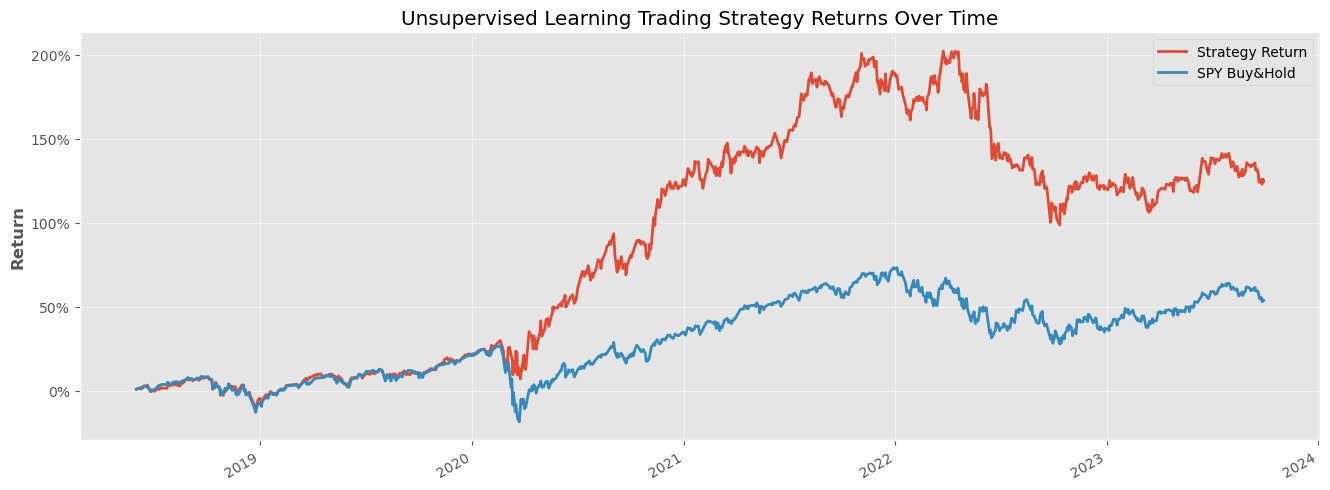

In [32]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()